In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
from IPython.display import clear_output
import h5py
from skimage.transform import resize
import sys
import glob


In [8]:
def create_specimen_dict_old(specimen='S1S2'):               
    d = {}
    # key = 'raw' or 'label'
    # value = np 3d array (0-255 or binary)
    imgs = list()
    for root, dirs, files in os.walk("."):
        if specimen in root:
            files = sorted(files)
            for name in files: 
                if ".tif" in name: 
                    path = os.path.join(os.path.abspath(root), name)
                    matrix = cv2.imread(path,cv2.IMREAD_UNCHANGED) # all uint8 when read in
                    imgs.append(matrix)
                    del matrix
            
            if "Med3D" in root: # raw
                d['raw'] = np.transpose(np.array(imgs),axes = (1,2,0)) # (1010, 980, 900)
            elif "Bernsen" in root: # label
                d['label'] = np.transpose(np.array(imgs),axes = (1,2,0)) # (1010, 980, 900)
            imgs = list()
    # convert to binary
    d['label'][d['label']==255]=1 # 0 = black; 255 or 1 = white
    d['label'] = 1-d['label'] # 0=1 = black; 0 = white
    
    return d

In [9]:
def create_specimen_dict(specimen='S1S2'):
    def initialize_rand(specimen): 
        # helper function to return a randomly initialized 3D matrix. 
        # get size 
        for root, dirs, files in os.walk("."):
            if specimen in root:
                # read one file to get image size
                files = sorted(files)
                matrix = cv2.imread(os.path.join(os.path.abspath(root),files[1]),cv2.IMREAD_UNCHANGED)
                tifCounter = len(glob.glob1(root,"*.tif"))
                if (tifCounter != 900) and (tifCounter != 749):
                    print(tifCounter)
                assert (tifCounter == 900) or (tifCounter == 749)
                break
        return np.random.rand(matrix.shape[0],matrix.shape[1],tifCounter) # e.g. (1010, 980, 900)
                        
    d = {}
    # key = 'raw' or 'label'
    # value = np 3d array (0-255 or binary)
    imgs = initialize_rand(specimen)
    for root, dirs, files in os.walk("."):
        if specimen in root:
            files = sorted(files)
            tifCounter = 0
            for name in files: 
                if ".tif" in name: 
                    path = os.path.join(os.path.abspath(root), name)
                    imgs[:,:,tifCounter] = cv2.imread(path,cv2.IMREAD_UNCHANGED) # all uint8 when read in
                    tifCounter += 1
            
            if "Med3D" in root: # raw
                d['raw'] = imgs
            elif "Bernsen" in root: # label
                d['label'] = imgs
    # convert to binary
    d['label'][d['label']==255]=1 # 0 = black; 255 or 1 = white
    d['label'] = 1-d['label'] # 0=1 = black; 0 = white
    
    return d

In [10]:
# 3D Plot function
# input: 3d np Array
def plot_binary_3D(array):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(array,facecolors='#1f77b430')
    plt.show()

def explode(data): 
    # helper function for plot_colormap_3D()
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def plot_colormap_3D(A,cmap):
    norm= plt.Normalize(A.min(), A.max())
    n_voxels=norm(A)

    facecolors = cmap(n_voxels)

    # upscale the above voxel image, leaving gaps
    fcolors_2 = explode(facecolors)
    filled_2 = fcolors_2[:,:,:,-1] != 0

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.01
    y[:, 0::2, :] += 0.01
    z[:, :, 0::2] += 0.01
    x[1::2, :, :] += 0.99
    y[:, 1::2, :] += 0.99
    z[:, :, 1::2] += 0.99

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(x, y, z, filled_2, facecolors=fcolors_2)

    m = cm.ScalarMappable(cmap='vivian', norm=norm)
    m.set_array([])
    plt.colorbar(m)
    plt.show()

def crop_center(array_3d,crop_dim):
    x,y,z = array_3d.shape
    startx = x//2 - crop_dim//2
    starty = y//2 - crop_dim//2   
    startz = z//2 - crop_dim//2  
    print(startx,starty,startz)
    return array_3d[startx:(startx+crop_dim), starty:(starty+crop_dim), startz:(startz+crop_dim)]



# Run above every time

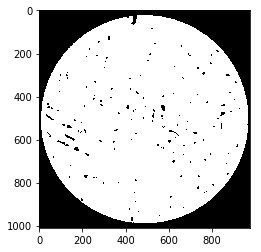

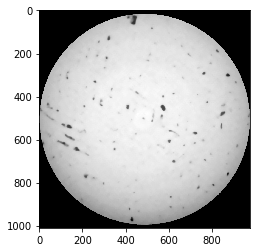

In [14]:
# meta_masks = []
# meta_files = []
for root, dirs, files in os.walk("."):
    for name in files:
        path = os.path.join(os.path.abspath(root), name)
        if name == 'Set1Sample2C-recon_Export0051_median3D_NLM_8bit_000.tif':
            im=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img_rgb = cv2.imread(path)
            plt.imshow(im, cmap = plt.cm.gray)
            plt.show()
        if name == 'S1S2_Bernsen_r5_lc15_crop_0000.tif':
            mask=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            plt.imshow(mask, cmap = plt.cm.gray)
            plt.show()
            
#         filename, file_extension = os.path.splitext(name)
#         if file_extension == '.tif' and 'Bernsen' in s:
#             print(filename)
    

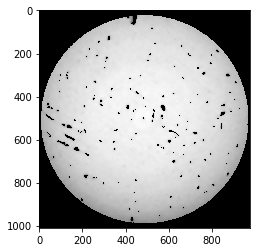

In [4]:
# overlay mask on top of image 
res = cv2.bitwise_and(im,im,mask = mask)
plt.imshow(res, cmap = plt.cm.gray)
plt.show()

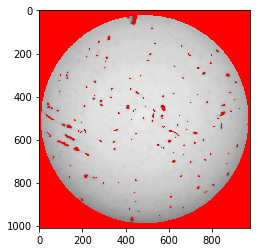

In [5]:

Conv_hsv_Gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)

indices = np.where(mask==0)
img_rgb[indices[0], indices[1], :] = [0, 0, 255]

# plt.axis("off")
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
print(mask.shape) #(1010,980); 0s = black. 
print(img_rgb.shape) #(1010,980,3); 0s = black. 

(1010, 980)
(1010, 980, 3)


# 3D Plot for specimen S1S2

In [4]:
d = create_specimen_dict('S1S2')
img_3d = d['raw']
mask_3d = 1-d['label'] # 0 = black; 1 = white
print(img_3d.shape) # range (0,255)
print(mask_3d.shape) # binary 0,1

(1010, 980, 900)
(1010, 980, 900)


In [5]:
# crop to a cube
crop_dim = 100

mask_3d_cropped = crop_center(mask_3d, crop_dim)
print(mask_3d_cropped.shape)

455 440 400
(100, 100, 100)


In [6]:
mask_3d_cropped.all() # should be false. True means all of cube is defect

False

In [16]:



img_3d_cropped = crop_center(img_3d, crop_dim)
defect = img_3d_cropped[60:100,60:100,90:100] 
print(defect)
print(defect.max())

455 440 400
[[[241 242 243 ... 241 241 241]
  [241 242 243 ... 241 241 241]
  [241 242 243 ... 241 241 241]
  ...
  [237 237 237 ... 231 226 221]
  [237 237 237 ... 231 227 222]
  [237 237 237 ... 232 228 225]]

 [[240 241 242 ... 240 240 240]
  [241 241 242 ... 240 240 240]
  [241 242 242 ... 240 240 240]
  ...
  [236 236 236 ... 231 226 220]
  [236 237 237 ... 231 227 222]
  [237 237 237 ... 231 228 224]]

 [[240 241 242 ... 240 240 240]
  [241 241 242 ... 240 240 240]
  [241 241 242 ... 240 240 240]
  ...
  [236 236 236 ... 231 227 221]
  [236 236 236 ... 231 227 223]
  [236 237 237 ... 231 228 225]]

 ...

 [[231 230 230 ... 231 232 233]
  [232 231 231 ... 231 232 233]
  [232 232 231 ... 231 231 232]
  ...
  [230 231 230 ... 218 206 197]
  [231 231 231 ... 221 213 204]
  [231 231 230 ... 223 218 212]]

 [[231 231 231 ... 231 231 232]
  [232 231 231 ... 231 231 232]
  [233 232 232 ... 231 231 232]
  ...
  [231 231 231 ... 223 219 215]
  [231 231 231 ... 225 221 218]
  [231 231 231 .

plot of a cube sampled from the center


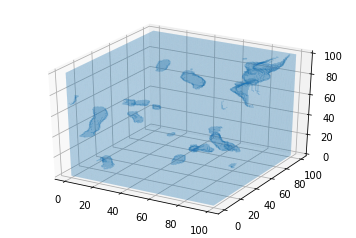

In [78]:
# only side face colors are renderred. so deeper color = where (mask==0) = defect
print("plot of a cube sampled from the center")
plot_binary_3D(mask_3d_cropped)

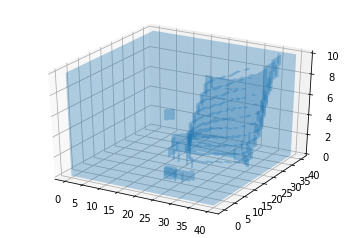

In [26]:
interesting_defect = mask_3d_cropped[60:100,60:100,90:100] 
plot_binary_3D(interesting_defect)

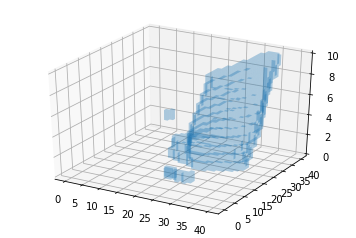

In [93]:
plot_binary_3D((1-interesting_defect))

455 440 400


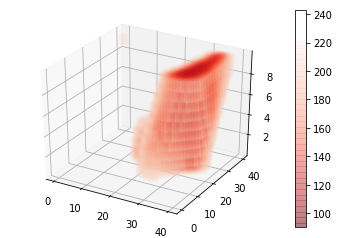

In [23]:
# create cmap 
ncolors = 256
color_array = plt.get_cmap('Reds_r')(range(ncolors))

# change alpha values
# color_array[:,-1] = np.linspace(0.3,0.0,ncolors)
grey_threshold = 220 # threshold at 220 to make grayish entirely transparent 
color_array[:,-1] = np.zeros((ncolors,))
color_array[:grey_threshold,-1] = np.linspace(0.3,0.1,grey_threshold) 

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='vivian',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)
cmap = plt.get_cmap('vivian')



img_3d_cropped = crop_center(img_3d, crop_dim)
defect = img_3d_cropped[60:100,60:100,90:100] 
plot_colormap_3D(defect,cmap)

In [96]:
# downsize and plot whole mask 
DOWNSIZED_DIM = 100
mask_3d_downsized = resize(mask_3d, (DOWNSIZED_DIM, DOWNSIZED_DIM, DOWNSIZED_DIM))
print(mask_3d_downsized.shape)
img_3d_downsized =  resize(img_3d, (DOWNSIZED_DIM, DOWNSIZED_DIM, DOWNSIZED_DIM))

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.



(100, 100, 100)


plot of mask downsized


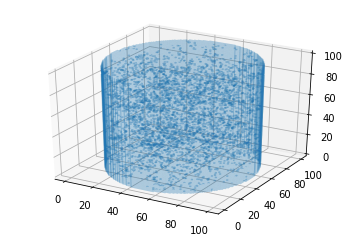

In [21]:
print("plot of mask downsized")
plot_binary_3D(mask_3d_downsized)

In [97]:
plot_colormap_3D(img_3d_downsized,cmap)

KeyboardInterrupt: 

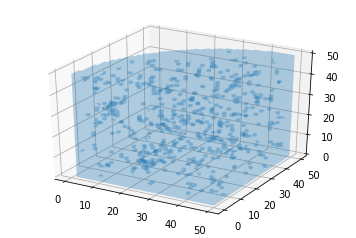

In [103]:
# plot a section
plot_binary_3D(mask_3d_downsized[:50,50:,:50])

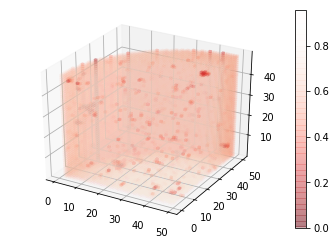

In [102]:
# don't plot zeros
# create cmap 
ncolors = 256
color_array = plt.get_cmap('Reds_r')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.3,0.0,ncolors)
color_array[:,-1][0]=0.0

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='vivian2',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)
cmap = plt.get_cmap('vivian2')

plot_colormap_3D(img_3d_downsized[:50,50:,:50],cmap)

## Convert to h5 format

In [3]:
# Assign filename: file
file = '../resources/sample_patch.h5'

# Load file: data
data = h5py.File(file, 'r')

# Print the datatype of the loaded file
print(type(data))

# Print the keys of the file
for k,v in data.items():
    print((k,v))


<class 'h5py._hl.files.File'>
('big_label', <HDF5 dataset "big_label": shape (64, 200, 200), type "<i8">)
('label', <HDF5 dataset "label": shape (64, 200, 200), type "<i8">)
('raw', <HDF5 dataset "raw": shape (64, 200, 200), type "<u2">)


In [5]:
print(data['label'].shape)
print(data['label'].value)
print(data['label'].dtype)

(64, 200, 200)
[[[ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  ...
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]]

 [[ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  ...
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]]

 [[ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  ...
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]]

 ...

 [[ 3  3  3 ...  3  3  3]
  [ 3  3  3 ...  3  3  3]
  [ 3  3  3 ... 28 28 28]
  ...
  [ 1  1  1 ... 32 32 32]
  [ 1  1  1 ... 32 32 32]
  [ 1  1  1 ... 32 32 32]]

 [[ 3  3  3 ...  3  3  3]
  [ 3  3  3 ...  3  3  3]
  [ 3  3  3 ...  3  3  3]
  ...
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]]

 [[ 3  3  3 ...  3  3  3]
  [ 3  3  3 ...  3  3  3]
  [ 3  3  3 ...  3  3  3]
  ...
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  1]
  [ 1  1  1 ...  1  1  

In [8]:
print(data['raw'].shape)
print(data['raw'].value) # np nd array
print(data['raw'].dtype)

(128, 128, 128)
[[[0.5019277  0.28485208 0.75848987 ... 0.54601904 0.27454819 0.08144852]
  [0.2956634  0.32007844 0.82348789 ... 0.08291161 0.99237199 0.61164045]
  [0.61468313 0.82774286 0.51882651 ... 0.80950851 0.16539336 0.43777267]
  ...
  [0.02539484 0.98232577 0.70759617 ... 0.28845296 0.85344695 0.60304102]
  [0.85340643 0.74311225 0.38967936 ... 0.39031748 0.23350852 0.36927835]
  [0.33376629 0.39827471 0.7284286  ... 0.10167708 0.98045943 0.36922605]]

 [[0.37232364 0.20908043 0.50659363 ... 0.89458273 0.43384498 0.25347409]
  [0.77658858 0.80930336 0.63871378 ... 0.14800208 0.39487863 0.75244148]
  [0.63551601 0.08507588 0.09242737 ... 0.79944167 0.44737348 0.94370148]
  ...
  [0.46078503 0.36678788 0.90397426 ... 0.39468455 0.43088066 0.51223671]
  [0.29140953 0.85282435 0.72478156 ... 0.4441414  0.37595051 0.88187625]
  [0.88282201 0.63386657 0.20180171 ... 0.58258261 0.97306282 0.64394314]]

 [[0.12768098 0.94750516 0.72595825 ... 0.75114042 0.81521551 0.98856806]
  [0.7

In [11]:
def normalize(A):
    # normalize across entire 3d matrix
    # convert to float32 to save memory
    return ((A-A.min())/(A.max()-A.min())).astype(np.float32)

# loop over all specimens and get 3d np array of each (label + raw)
# store each specimen as train_file_?.h5
# crop to half the array size so it's S1S2_1, S1S2_2. because ram won't fit
"""
Need to edit train_config_.yaml
train_path:
    - '/h5_files/train_file_1.h5'
    - '/h5_files/train_file_2.h5'
"""  

specs = ['S1S4','S1S5','S1S6']
for spec in specs:
    d = create_specimen_dict(spec)
    print(d['raw'].shape)
    print(d['label'].shape)
    
#     for num in [0,1]:
#         save_path = 'h5_files/float32/NIST_specimen_{}_{}.h5'.format(spec,num)
    save_path = 'h5_files/float32/NIST_specimen_{}.h5'.format(spec)
        
    hf = h5py.File(save_path, 'w')
    hf.create_dataset('raw',data = normalize(d['raw']),chunks=True, compression='gzip')
    hf.create_dataset('label',data = normalize(d['label']),chunks=True, compression='gzip')
#         hf.create_dataset('raw', data = normalize(np.array_split(d['raw'],2,axis=2)[num]), chunks=True, compression='gzip')
#         hf.create_dataset('label', data = np.array_split(d['label'],2,axis=2)[num], chunks=True, compression='gzip')
    hf.close()
    del d

900
(1010, 984, 900)
(1010, 984, 900)
749
(1010, 984, 749)
(1010, 984, 749)
900
(1013, 984, 900)
(1013, 984, 900)


In [5]:
spec

'S1S5'

In [14]:
hf.close()

In [10]:
x = np.arange(7.0)
np.array_split(x, 2)

[array([0., 1., 2., 3.]), array([4., 5., 6.])]

In [8]:
# Assign filename: file
file = '../NIST_specimen_S1S2_1_predictions.h5'
# Load file: data
data_1 = h5py.File(file, 'r')

file = '../NIST_specimen_S1S2_0_predictions.h5'
data_0 = h5py.File(file, 'r')

data = np.concatenate((data_0['predictions'].value,data_1['predictions'].value),axis=3)
print(data.shape)
# # Print the datatype of the loaded file
# print(type(data))

# # Print the keys of the file
# for k,v in data.items():
#     print((k,v))

binary_pred = np.where(data[1,:,:,:]>0.5,1,0)
print(binary_pred.shape)
print(binary_pred.min())
print(binary_pred.max())

In [26]:
binary_truth = 1-mask_3d

In [28]:
binary_truth_cropped = crop_center(binary_truth,100)
binary_pred_cropped = crop_center(binary_pred,100)

455 440 400
455 440 400


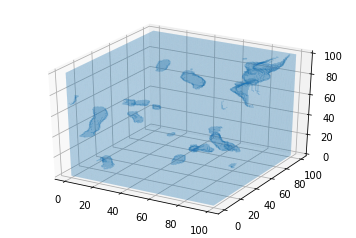

In [32]:
plot_binary_3D(1-binary_truth_cropped)

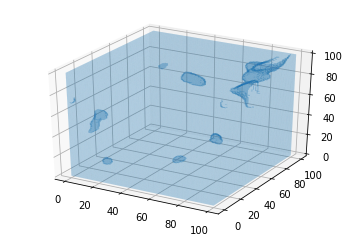

In [31]:
plot_binary_3D(1-binary_pred_cropped)

In [34]:
np.sum(binary_truth==binary_pred)/(1010*980*900)

0.9939080678476011

In [7]:
import torch
from torch import nn as nn

m = nn.Dropout3d(p=0.2)
input = torch.randn(20, 32, 32)
output = m(input)

print(output.shape)

torch.Size([20, 32, 32])


In [ ]:
def dropout3d(p=0.5):
    return nn.Dropout3d(p=0.5)

drop

# showing slice 100 for paper 2

In [19]:
# Assign filename: file
# file = './h5_files/DHW/NIST_specimen_S1S2_predictions.h5'
file = './h5_files/NIST_specimen_S1S2_0_predictions.h5'
# Load file: data
data = h5py.File(file, 'r')
print(data)
# # Print the datatype of the loaded file
# print(type(data))

# Print the keys of the file
for k,v in data.items():
    print((k,v))


<HDF5 file "NIST_specimen_S1S2_0_predictions.h5" (mode r)>
('predictions', <HDF5 dataset "predictions": shape (2, 1010, 980, 450), type "<f4">)
<HDF5 file "NIST_specimen_S1S2_0_predictions.h5" (mode r)>
('predictions', <HDF5 dataset "predictions": shape (2, 1010, 980, 450), type "<f4">)


In [20]:
data = data['predictions'].value
print(data.shape)

(2, 1010, 980, 450)


/Users/vivianwong/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


(2, 1010, 980, 450)


/Users/vivianwong/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


In [21]:
binary_pred = np.where(data[1,:,:,:]>0.5,1,0)
print(binary_pred.shape)
print(binary_pred.shape)

(1010, 980, 450)
(1010, 980, 450)
(1010, 980, 450)
(1010, 980, 450)


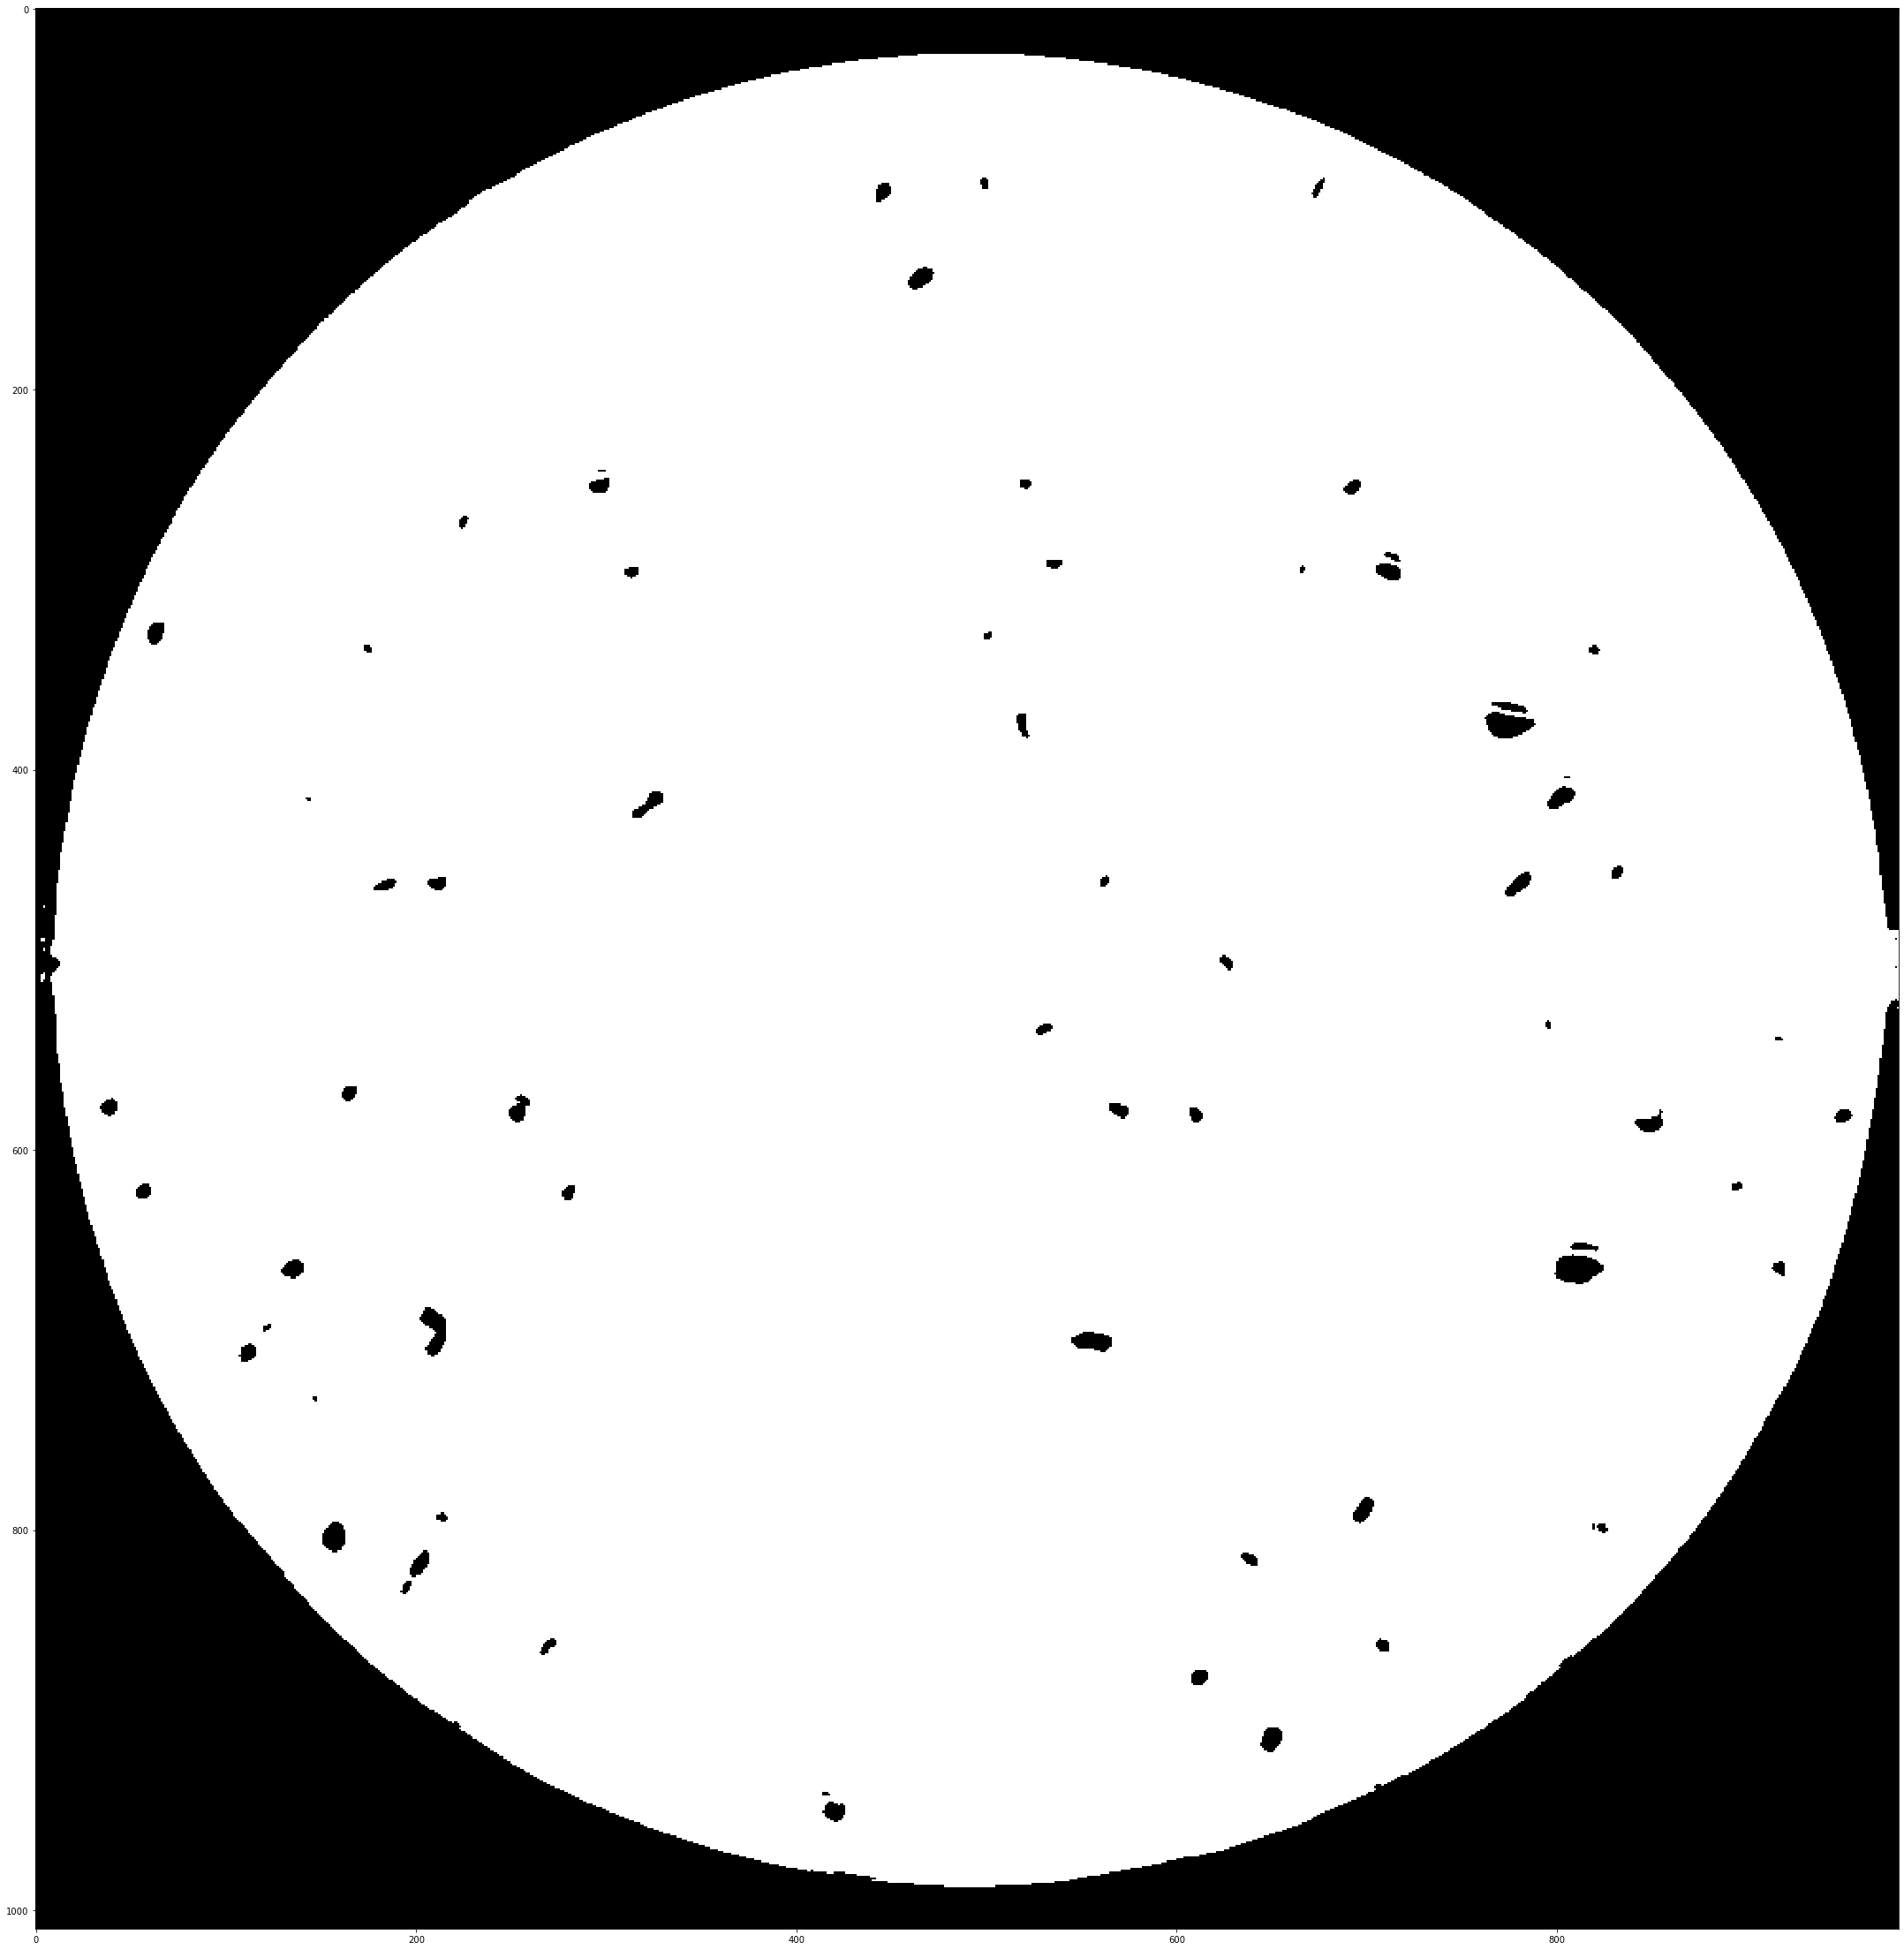

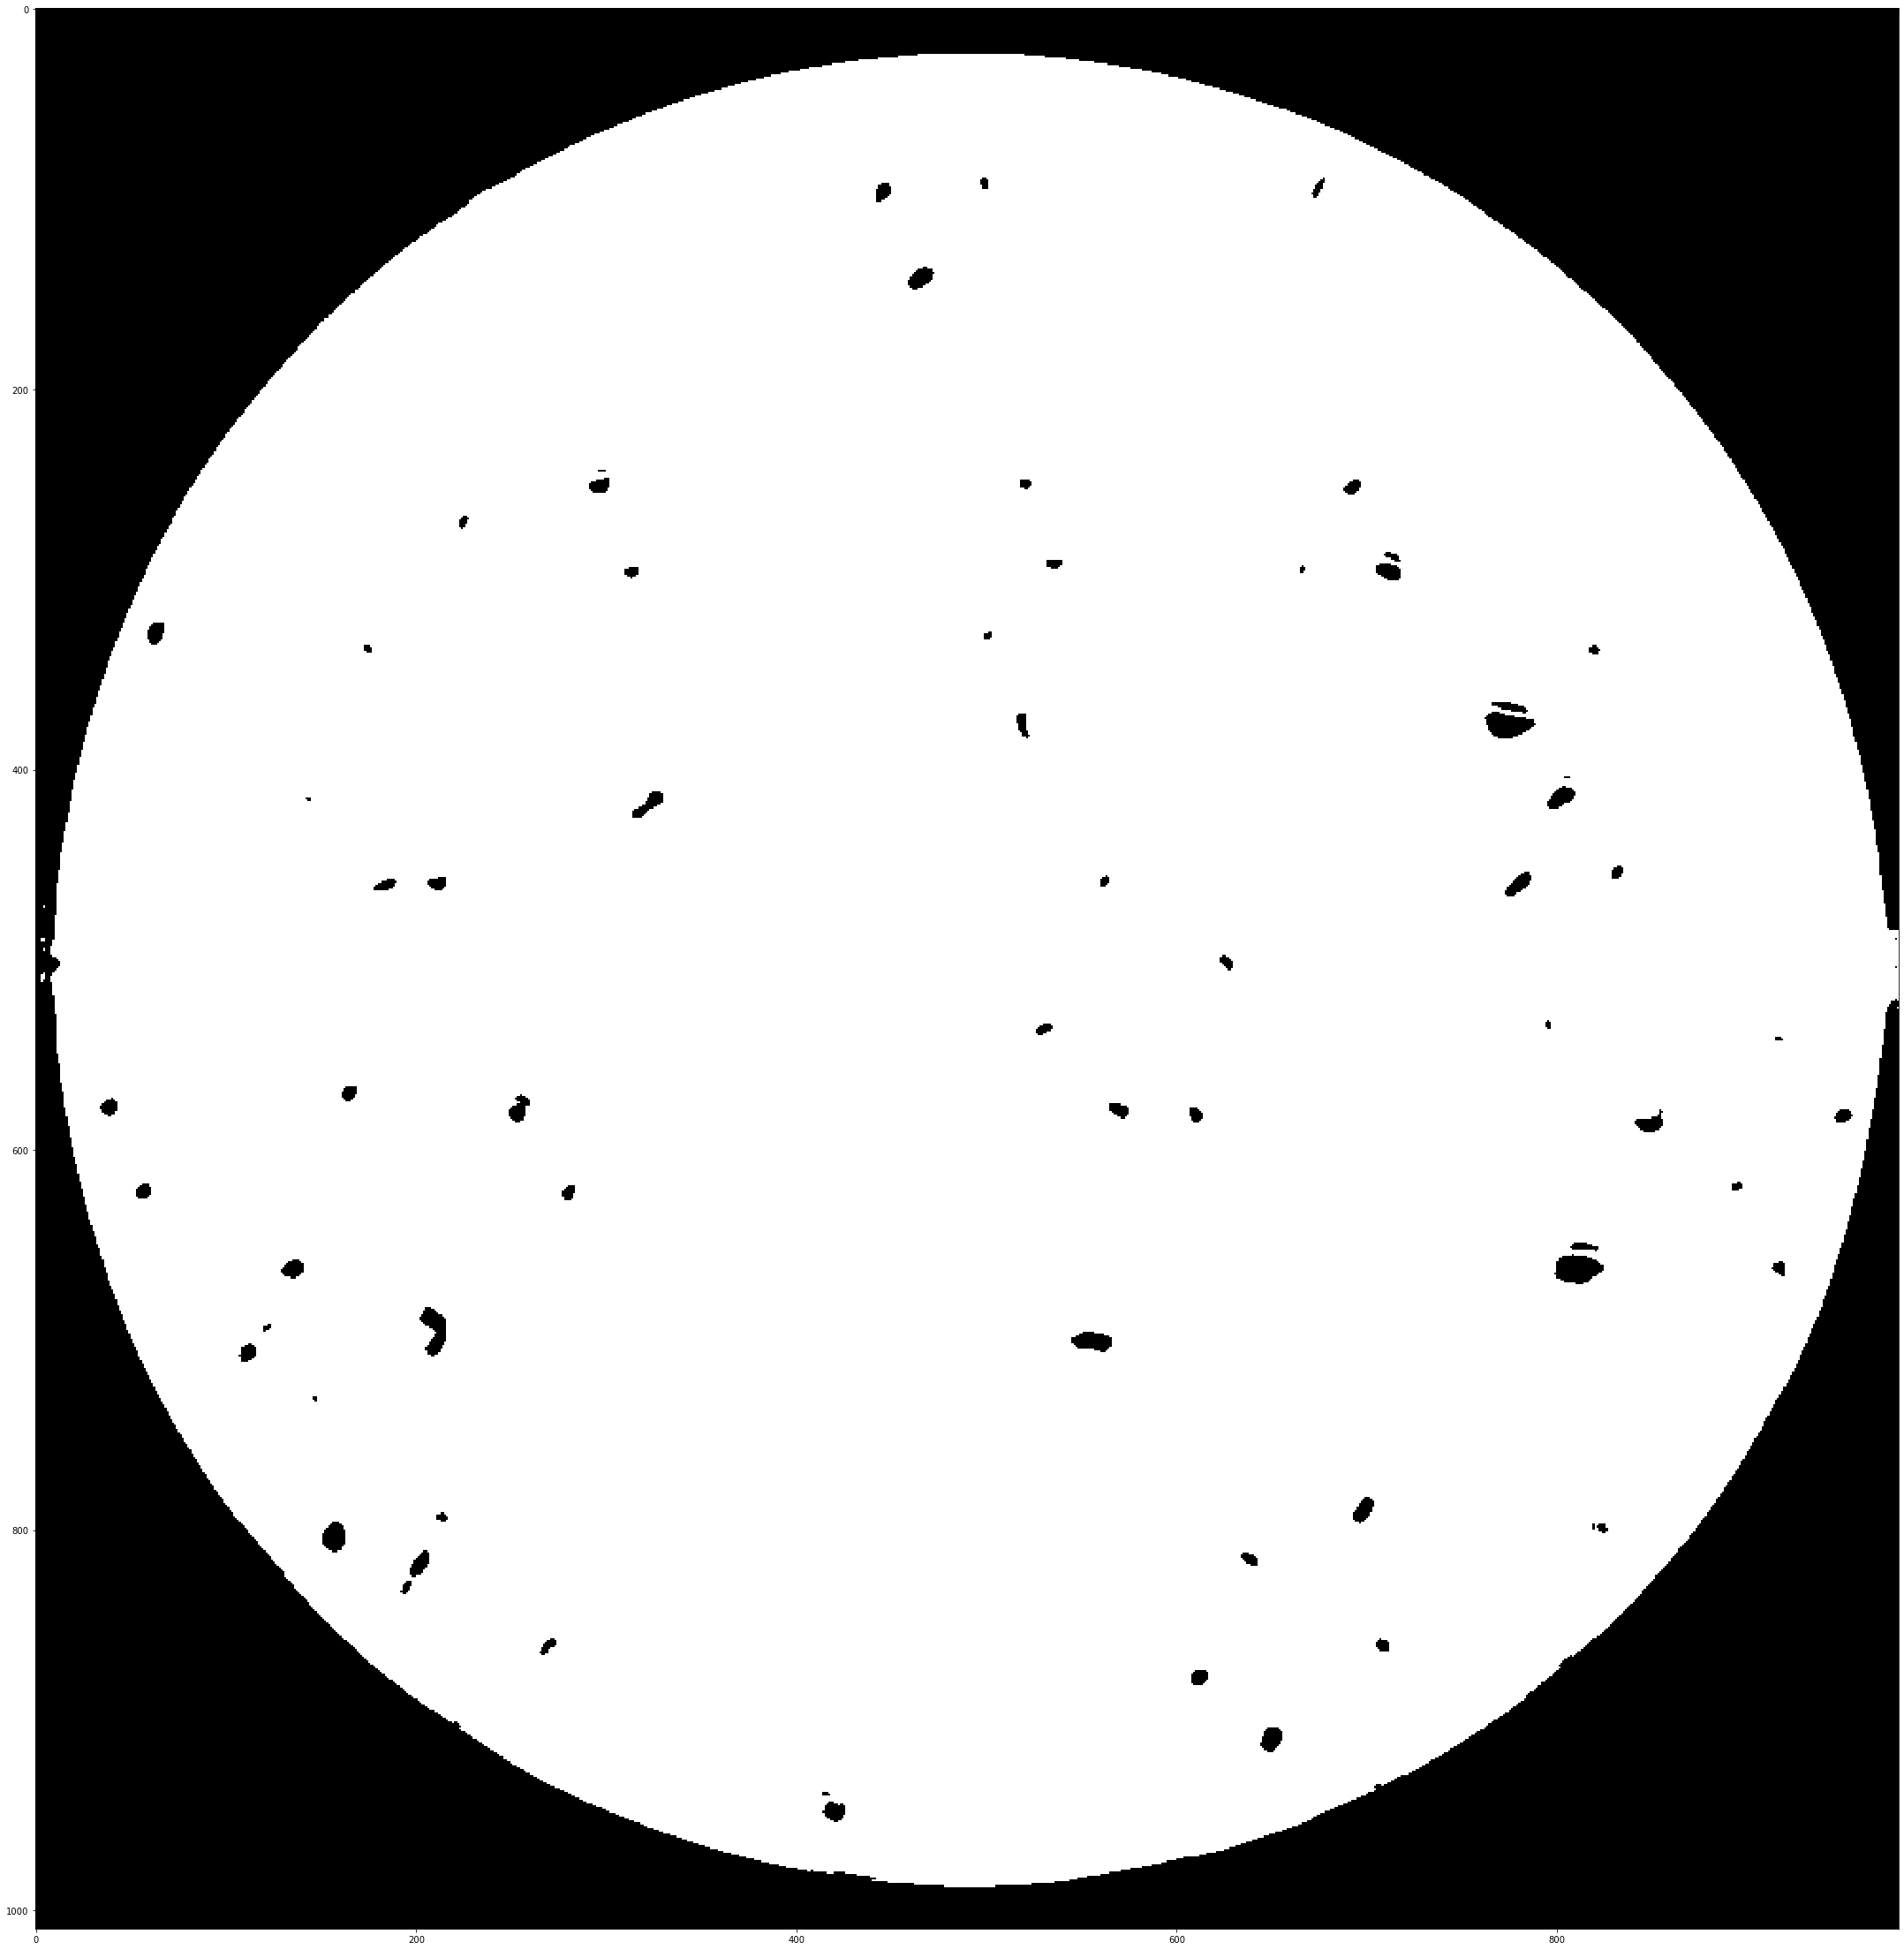

In [22]:
plt.figure(figsize = (40,40))
plt.imshow(binary_pred[:,:,100], cmap = 'Greys')
plt.show()

In [24]:
# Assign filename: file
# file = './h5_files/DHW/NIST_specimen_S1S2_predictions.h5'
file = './h5_files/DHW/NIST_specimen_S1S2_0.h5'
# Load file: data
data = h5py.File(file, 'r')
print(data)
# # Print the datatype of the loaded file
# print(type(data))
for k,v in data.items():
    print((k,v))


<HDF5 file "NIST_specimen_S1S2_0.h5" (mode r)>
('label', <HDF5 dataset "label": shape (225, 1010, 980), type "|u1">)
('raw', <HDF5 dataset "raw": shape (225, 1010, 980), type "<f4">)
<HDF5 file "NIST_specimen_S1S2_0.h5" (mode r)>
('label', <HDF5 dataset "label": shape (225, 1010, 980), type "|u1">)
('raw', <HDF5 dataset "raw": shape (225, 1010, 980), type "<f4">)


/Users/vivianwong/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.
/Users/vivianwong/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


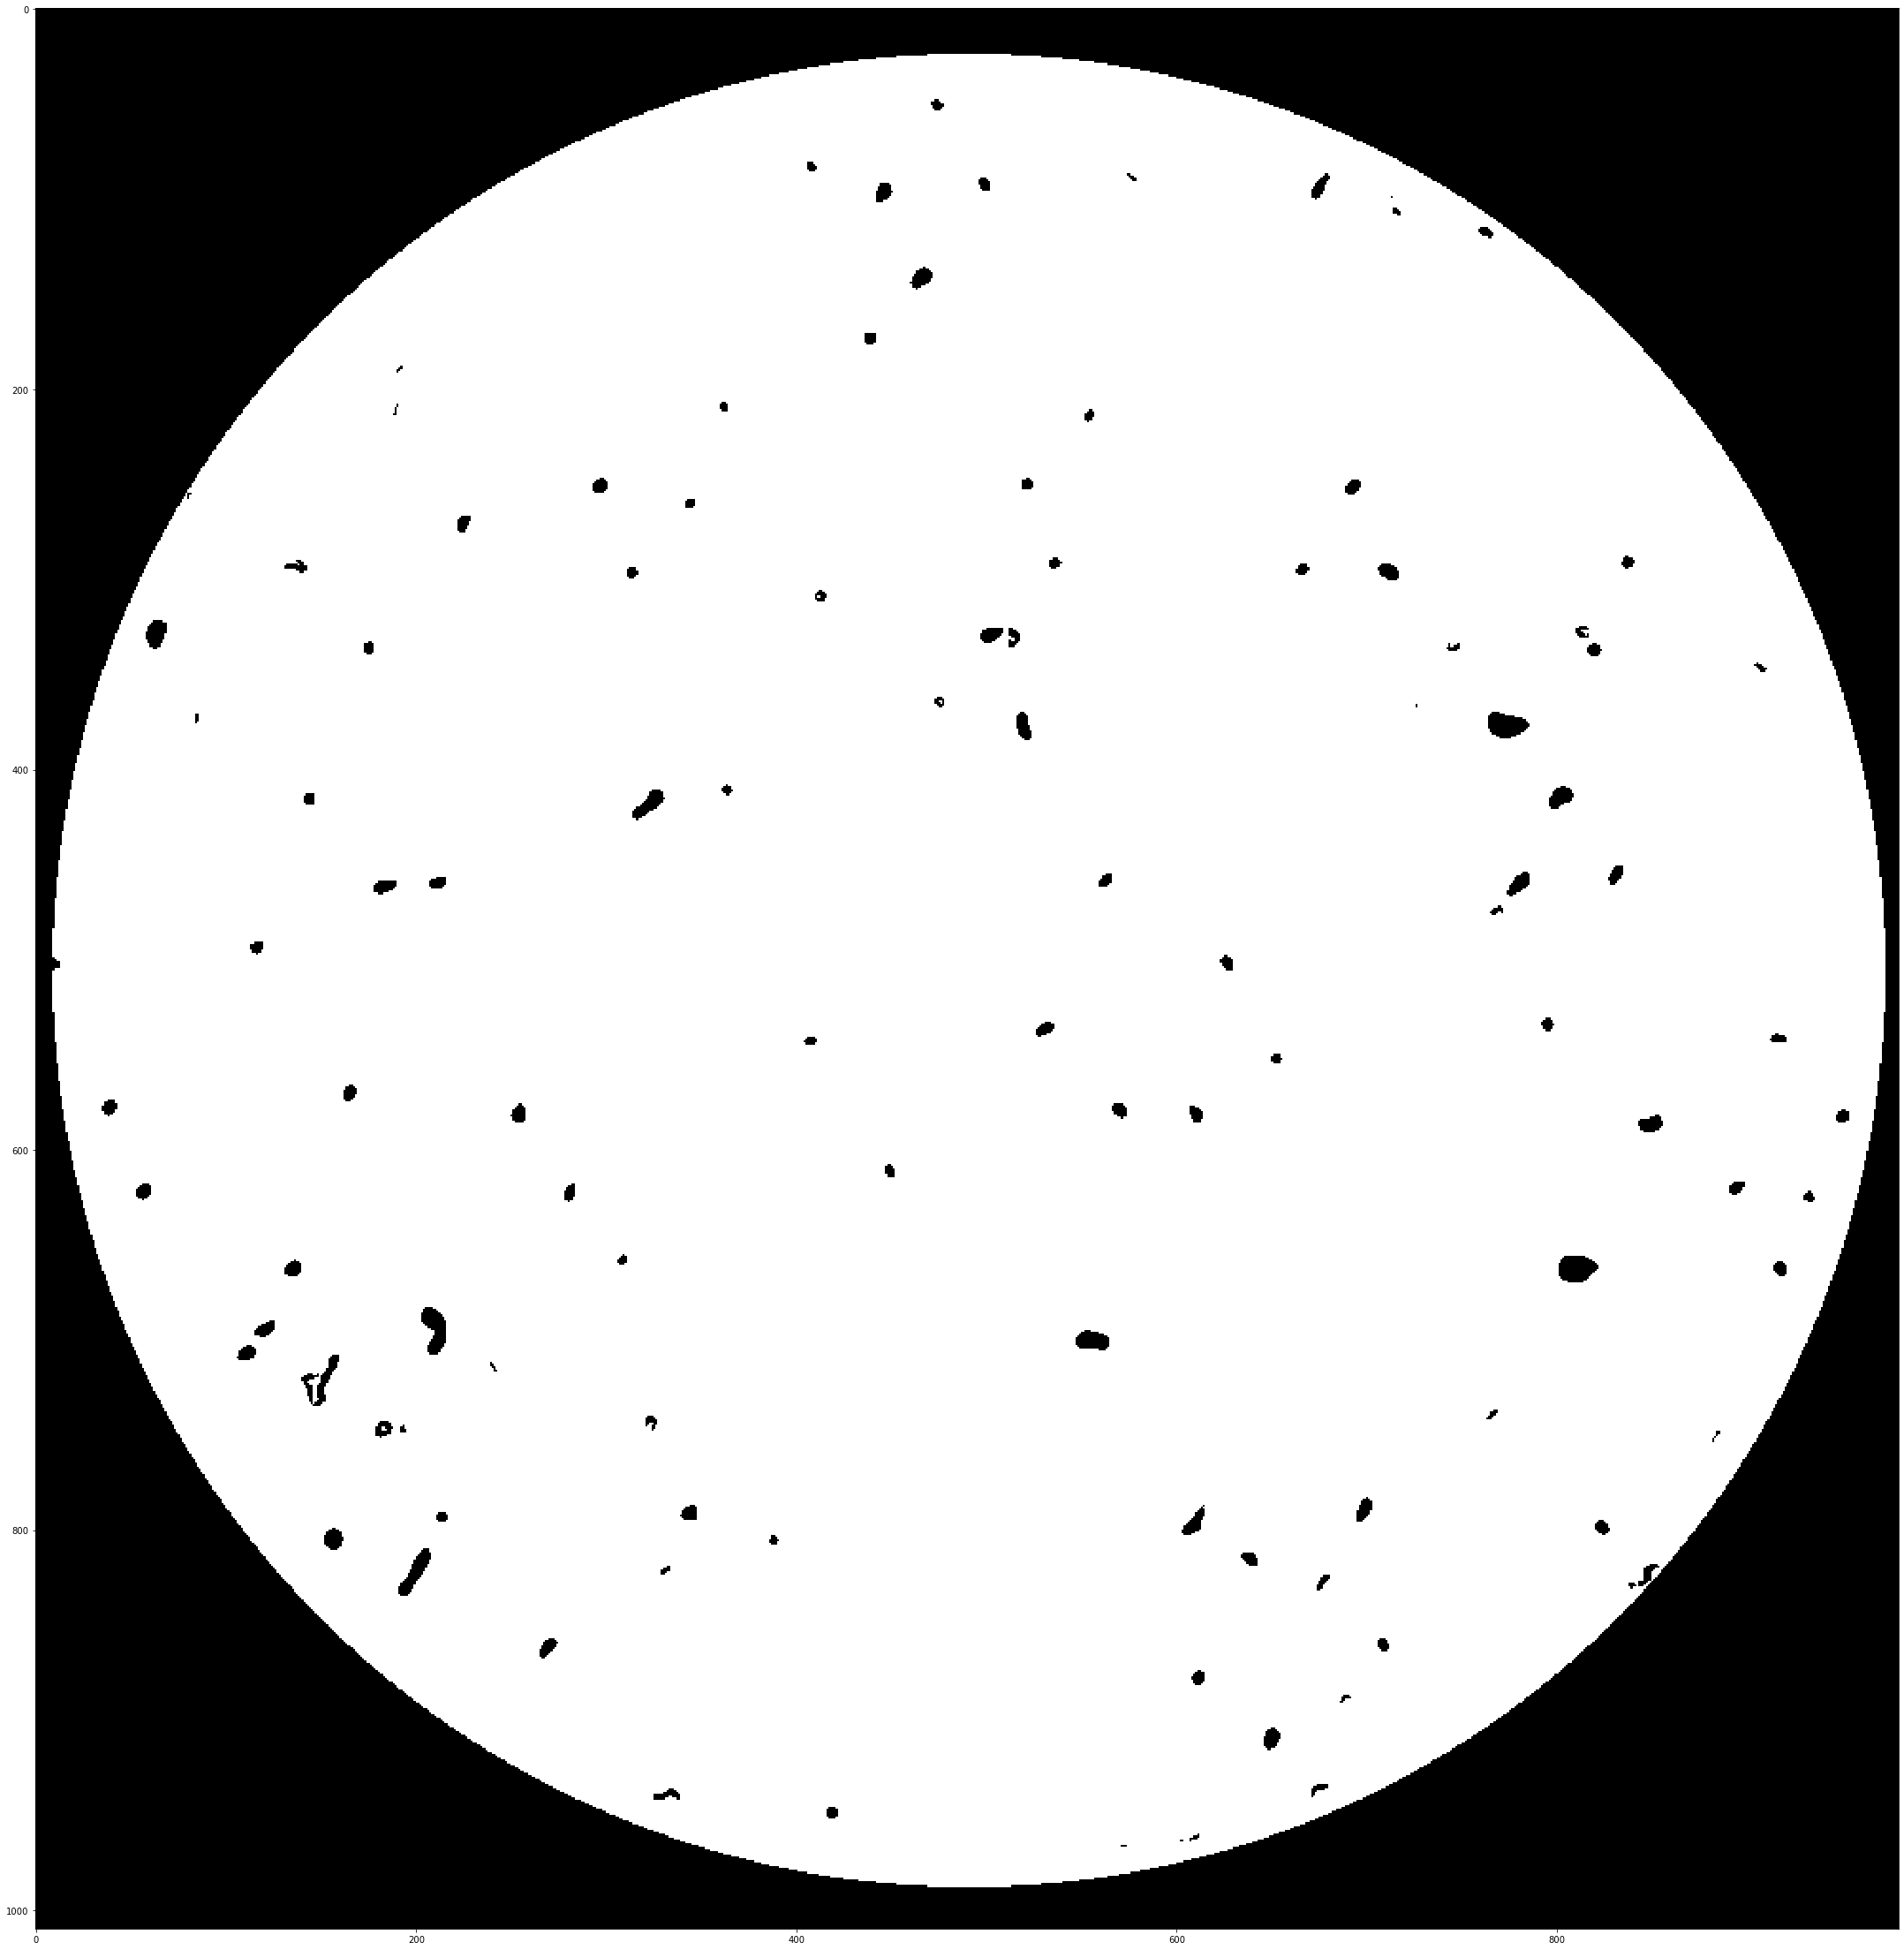

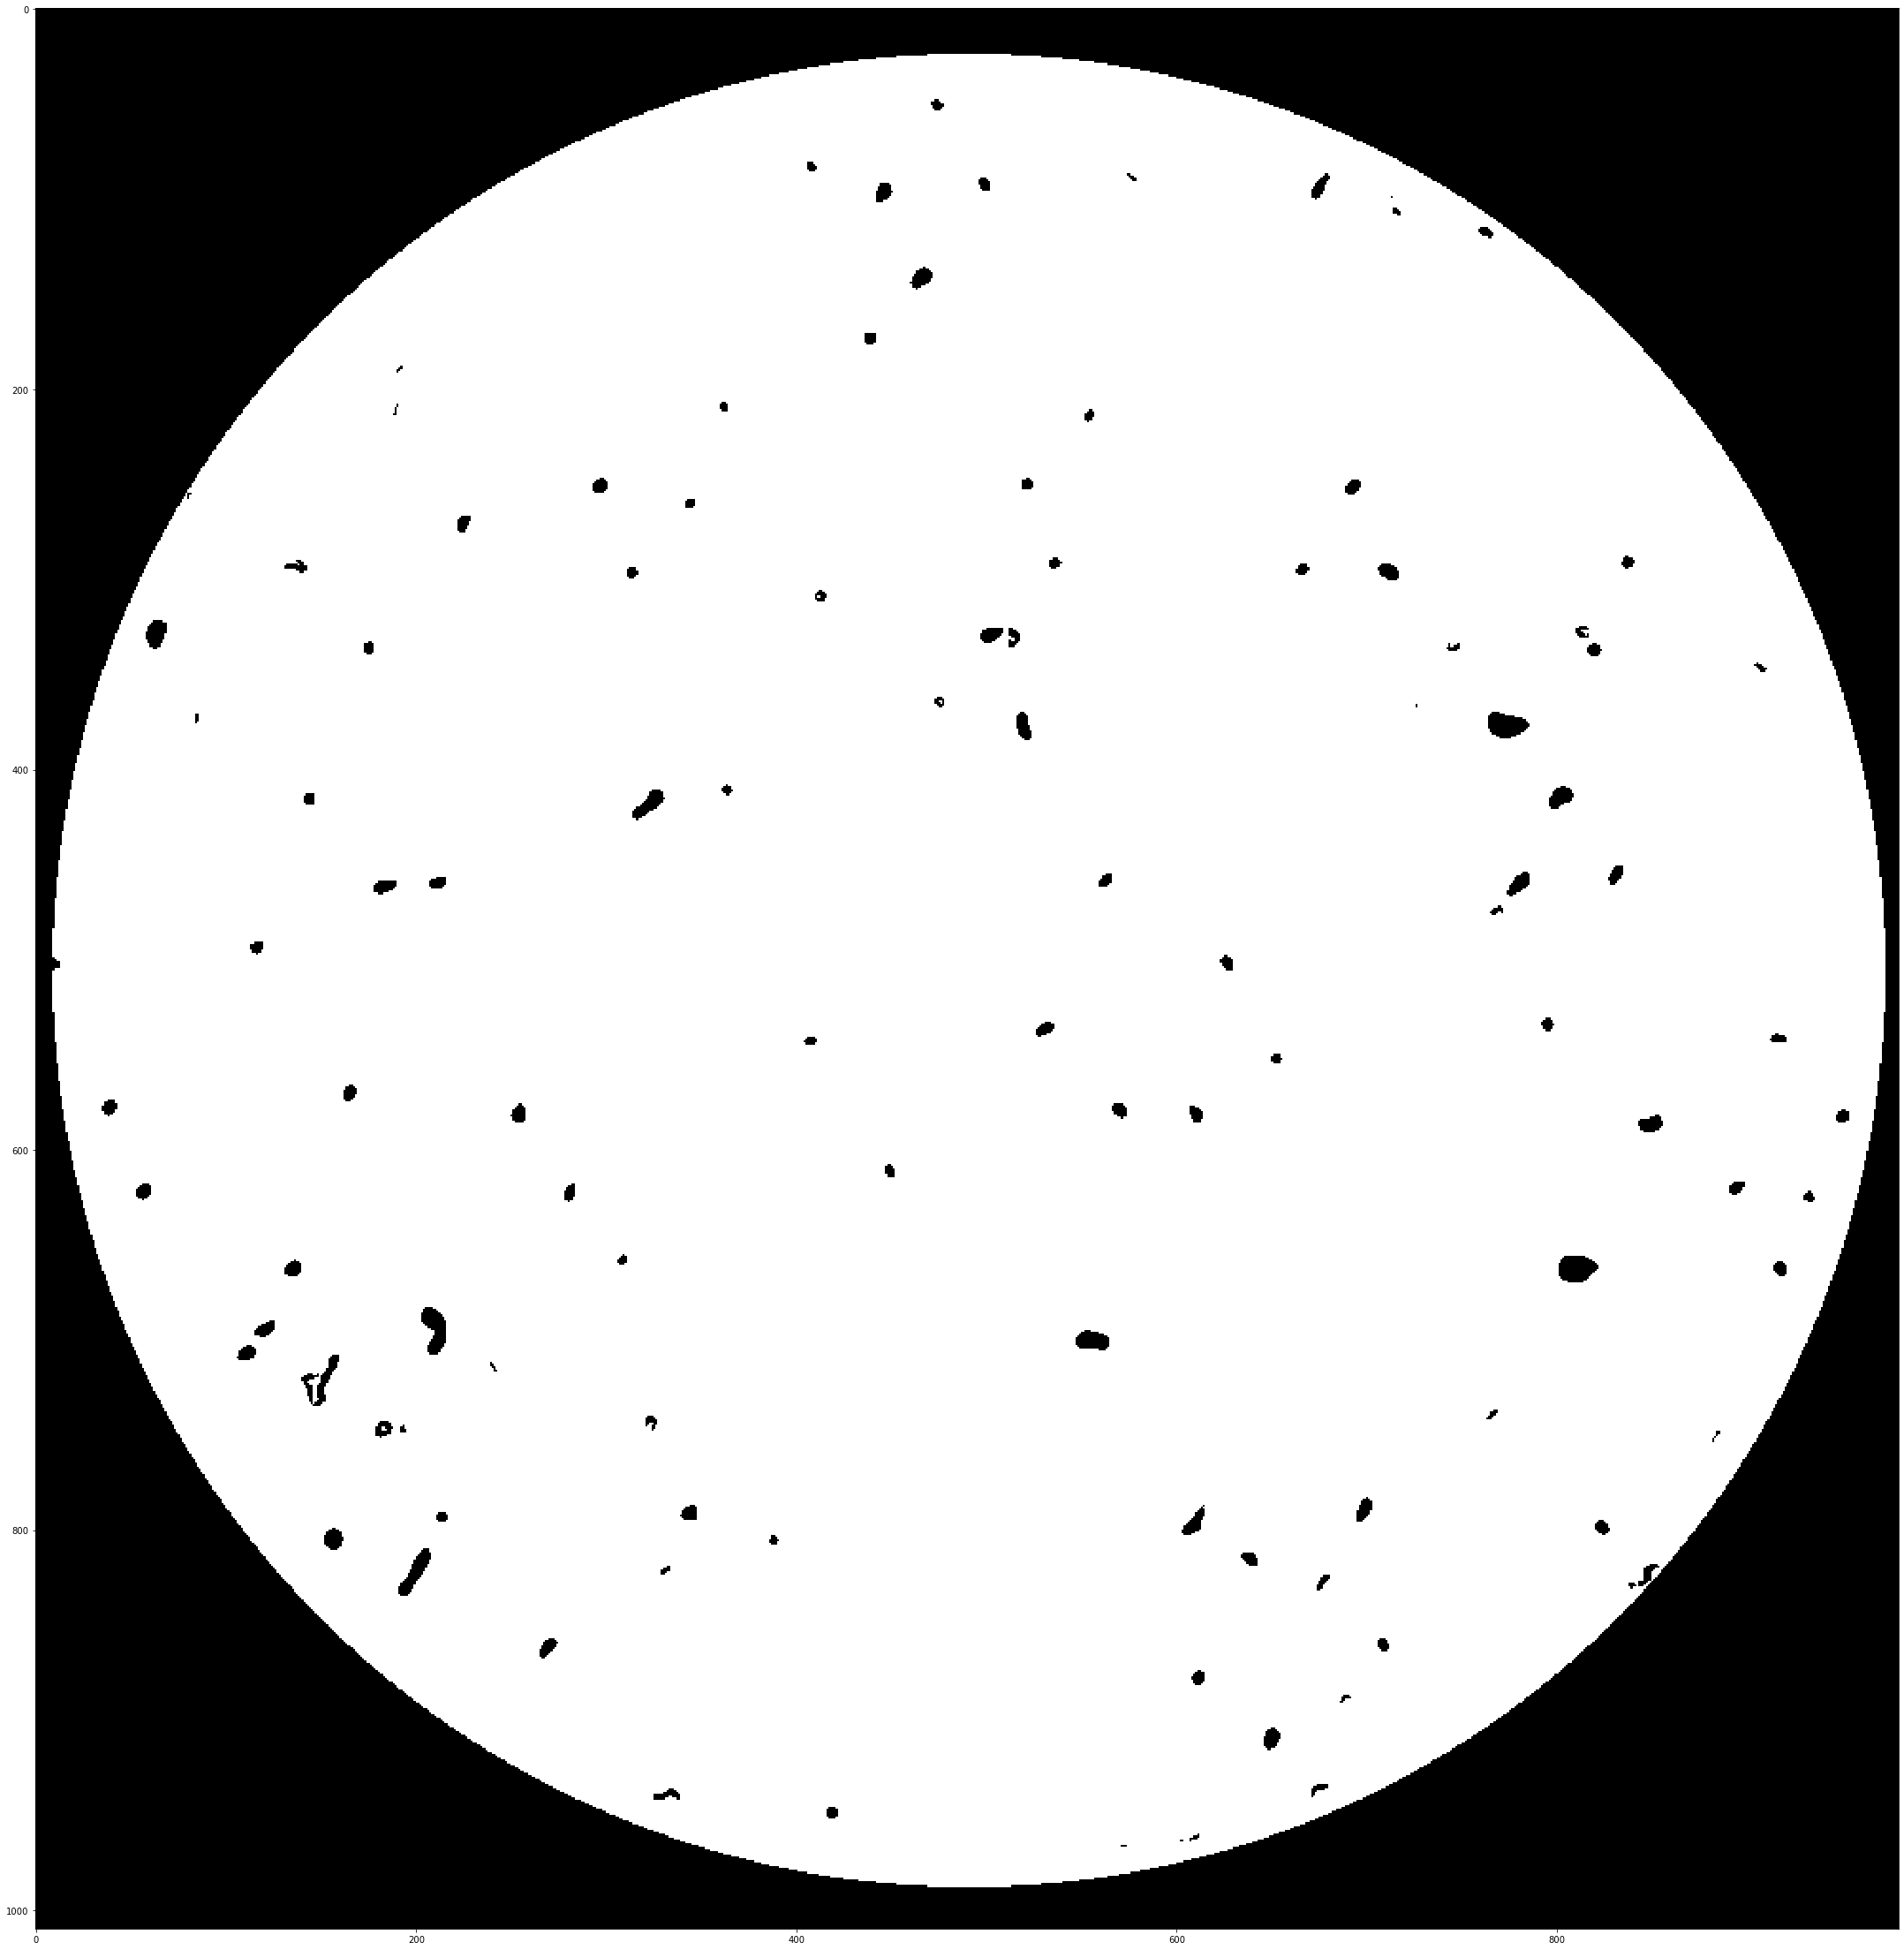

In [26]:
label = data['label'].value

plt.figure(figsize = (40,40))
plt.imshow(label[100,:,:], cmap = 'Greys')
plt.show()




In [31]:
# Assign filename: file
# file = './h5_files/DHW/NIST_specimen_S1S2_predictions.h5'
file = './h5_files/DHW/NIST_specimen_S1S5.h5'
# Load file: data
data = h5py.File(file, 'r')
for k,v in data.items():
    print((k,v))

('label', <HDF5 dataset "label": shape (749, 1010, 984), type "|u1">)
('raw', <HDF5 dataset "raw": shape (749, 1010, 984), type "<f4">)
('label', <HDF5 dataset "label": shape (749, 1010, 984), type "|u1">)
('raw', <HDF5 dataset "raw": shape (749, 1010, 984), type "<f4">)


In [32]:
900*1010*980

890820000

890820000